## Statistical analysis of the player paths data

**for the end of the week this should just be part of a big notebook that combines converstion of data into pandas dataframes preprossecing of these dataframes and statistical analysis. At the end of the notebook we should have the data we work with for all the follwing stuff**

In [186]:
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import numpy as np

In [64]:
#reload stored dataframes
article_df = feather.read_feather('Data/dataframes/article_dataframe.feather')
paths_df = feather.read_feather('Data/dataframes/paths.feather')

**Before doing analysis we add some usefull columns to the data frame**
- an identifier column for the same start and target pairs
- a column where the full path is converted into a list
- a column where only the direct path (no backward clicks) are considered and converted into a list
- respectively a column for the length of the two lists (path legths) described just above

In [65]:
# to have unique indexes
paths_df = paths_df.reset_index(drop=True)

# add an identifier for the same start-target articles pairs
paths_df['identifier'] = paths_df.groupby(['start_article', 'target_article']).ngroup()

In [66]:
# should be moved to some other place later

def process_path(path_string):
    # Split the input string by the ";" delimiter
    links = path_string.split(";")
    
    # Initialize lists for full path and simplified path
    full_path = []
    simplified_path = []
    
    # Traverse through each link in the path
    for link in links:
        # Handle backward steps
        if link == "<":
            if simplified_path: # make sure list is not empty befor pop
                simplified_path.pop()  # Go back by removing last entry
        else:
            full_path.append(link)
            simplified_path.append(link)
    
    return full_path, simplified_path

In [141]:
# add two new columns to the paths dataset with processed paths
paths_df[['full_path', 'simplified_path']] = paths_df['path'].apply(lambda x: pd.Series(process_path(x)))

# also add a column of for full and simplified path length
paths_df['full_path_length'] = paths_df['full_path'].apply(lambda x: len(x)-1) # n-1 is the distance
paths_df['simplified_path_length'] = paths_df['simplified_path'].apply(lambda x: len(x)-1)

In [142]:
paths_df.head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,full_path_length,simplified_path_length,distance
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,True,None,14th_century,African_slave_trade,48,"[14th_century, 15th_century, 16th_century, Pac...","[14th_century, 15th_century, 16th_century, Pac...",8,8,3.0


In [144]:
# check if it worked for a path with backward steps
p = paths_df.loc[16]
print(f"Original String Path:\n    {p['path']}\n")
print(f"Converted Full Path:\n    {p['full_path']}\n")
print(f"Converted Simplified Path:\n    {p['simplified_path']}\n")

Original String Path:
    14th_century;Europe;Republic_of_Ireland;<;<;Europe;<;Europe;Republic_of_Ireland;<;<;Time;Physics;Speed_of_light;Rainbow

Converted Full Path:
    ['14th_century', 'Europe', 'Republic_of_Ireland', 'Europe', 'Europe', 'Republic_of_Ireland', 'Time', 'Physics', 'Speed_of_light', 'Rainbow']

Converted Simplified Path:
    ['14th_century', 'Time', 'Physics', 'Speed_of_light', 'Rainbow']



In [145]:
# a function that takes as input two articles and computes the distance between them using the distance col from article_df 
# Should be added into a utils file or smth

def get_distance_between_articles(df, article1, article2):
    """
    Compute the distance between two articles based on the distance data in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing articles and their distance dictionaries.
        article1 (str): The name of the first article.
        article2 (str): The name of the second article.
        
    Returns:
        int or None: The distance between article1 and article2. Returns None if not found.
    """
    # Find the row where the article is article1
    row_article1 = df[df['article'] == article1]
    
    if row_article1.empty:
        print(f"Article '{article1}' not found in the DataFrame.")
        return None
    
    # Extract the dictionary of distances for article1
    distances_dict = row_article1['distances'].values[0]
    
    # Retrieve the distance to article2
    distance = distances_dict.get(article2)

    # this will return either an int or None
    return distance

In [146]:
# apply the function that computes distance between two articles to the path data frame
paths_df['distance'] = paths_df.apply(lambda row: get_distance_between_articles(article_df, row['start_article'], row['target_article']), axis=1)


### Outlier handling
before jumping into distribution analysis let's first see if there are potential outliers that need to be taken care of, this is easier when considering finished and unfinished paths seperately

In [147]:
paths_df['full_path_length'].describe()

finished_paths = paths_df[paths_df['finished']]
unfinished_paths = paths_df[~paths_df['finished']]

print(f"Finished path length statistics:\n    {finished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")
print(f"Unfinished path length statistics:\n    {unfinished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")



Finished path length statistics:
           full_path_length  simplified_path_length
count      51318.000000            51318.000000
mean           5.356775                4.956117
std            3.775778                3.288758
min            0.000000                0.000000
25%            3.000000                3.000000
50%            5.000000                4.000000
75%            6.000000                6.000000
max          419.000000              404.000000

Unfinished path length statistics:
           full_path_length  simplified_path_length
count      24875.000000            24875.000000
mean           3.678915                3.160040
std            4.595089                3.942539
min            0.000000                0.000000
25%            1.000000                1.000000
50%            3.000000                2.000000
75%            5.000000                4.000000
max          191.000000              148.000000



In [148]:
# there are some very long paths lets analyse them in more detail
finished_paths.sort_values(by='full_path_length', ascending=False).head(6)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,full_path_length,simplified_path_length,distance
8046,7f6da01d55086766,1248928447,2205,"United_States;Washington,_D.C.;Government;Corp...",5.0,True,None,United_States,English_language,39775,"[United_States, Washington,_D.C., Government, ...","[United_States, Washington,_D.C., Government, ...",419,404,2.0
19961,4f1b9ce764349901,1236685130,2292,Napoleon_I_of_France;United_Kingdom;Great_Brit...,NaN,True,None,Napoleon_I_of_France,Recycling,26826,"[Napoleon_I_of_France, United_Kingdom, Great_B...","[Napoleon_I_of_France, United_Kingdom, Great_B...",113,108,3.0
6945,4e97d9af4476607f,1248925083,1141,"Police_state;Police;United_States;Washington,_...",5.0,True,None,Police_state,African_slave_trade,30473,"[Police_state, Police, United_States, Washingt...","[Police_state, Police, United_States, Washingt...",102,101,3.0
27136,0d57c8c57d75e2f5,1290096241,1852,Lake_Toba;Netherlands;Europe;Earth;United_Stat...,5.0,True,None,Lake_Toba,Looney_Tunes,22232,"[Lake_Toba, Netherlands, Europe, Earth, United...","[Lake_Toba, Netherlands, Europe, Earth, United...",90,82,4.0
6659,7f6da01d55086766,1248923237,364,North_America;Pacific_Ocean;Earth;Earth's_atmo...,5.0,True,None,North_America,Canada,27769,"[North_America, Pacific_Ocean, Earth, Earth's_...","[North_America, Pacific_Ocean, Earth, Earth's_...",71,71,1.0
28393,7b740aba73fe91e2,1231967436,171,55_Cancri_c;Saturn;Zeus;Heracles;Rome;Christia...,1.0,True,None,55_Cancri_c,Niger,456,"[55_Cancri_c, Saturn, Zeus, Heracles, Rome, Ch...","[55_Cancri_c, Saturn, Zeus, Heracles, Rome, Ch...",64,62,4.0


In [149]:
# Judjing from the actual distance between the articles the paths taken seem overly complicated and 
# where probably purposfully added
# to confirm this lets look at the statistics of some of the paths with the same identifier:

print(f"Statistics of all paths that have the same start-target article pair as the longest path:\n    {finished_paths[finished_paths['identifier'] == 39775][['full_path_length', 'simplified_path_length']].describe()}\n")

print(f"Statistics of all paths that have the same start-target article pair as the 2nd longest path:\n    {finished_paths[finished_paths['identifier'] == 26826][['full_path_length', 'simplified_path_length']].describe()}\n")


Statistics of all paths that have the same start-target article pair as the longest path:
           full_path_length  simplified_path_length
count         15.000000               15.000000
mean          29.933333               28.933333
std          107.632620              103.759658
min            2.000000                2.000000
25%            2.000000                2.000000
50%            2.000000                2.000000
75%            2.000000                2.000000
max          419.000000              404.000000

Statistics of all paths that have the same start-target article pair as the 2nd longest path:
           full_path_length  simplified_path_length
count           4.00000                4.000000
mean           35.50000               34.000000
std            52.04165               49.672259
min             3.00000                3.000000
25%             6.75000                6.750000
50%            13.00000               12.500000
75%            41.75000               3

From the above we estimate that a smart way to handle outliers is to use the interquantile range (IQR) method method removing paths which have a length of more than 75% quantile + 1.5 x IQR. There are two possible approaches either to define global outlier or to define outliers per start-target article pair group. The latter however only makes sense if there are enough samples present per group. 

Since there are certainly differences in path difficulty between the groups the second appraoch would be more taylored but it requires a certain number of samples per group to be somewhat accurate.  Thus we first have a look at the statistics of start-target article pair group size.

In [150]:
# Get the counts of each identifier
pair_identifier_counts = finished_paths.groupby('identifier').size()

pair_identifier_counts.describe()

count    28718.000000
mean         1.786963
std         11.128460
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1043.000000
dtype: float64

Since overall there clearly is a very low amount of sample (close to 1) per start-target pair group, we have to use the global approach (for now). 
However, this can still be adapted to path difficulty to some extend, at least for the finished paths. In fact, we can do so by consider not directly the path length but the distance between path length and optimal length (shortest possible distance from start to finish article) and apply the IQR method on it.

In [195]:
finished_paths = finished_paths.copy()

# Calculate the difference between full_path_length and distance 
# NOTE: here I use full path not direct path, which is less conservative (can be changed depending on subsequent analysis)
finished_paths['length_minus_distance'] = finished_paths['full_path_length'] - finished_paths['distance']

# Calculate Q1 and Q3 based on the new difference col
Q1 = finished_paths['length_minus_distance'].quantile(0.25)
Q3 = finished_paths['length_minus_distance'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the upper bound
upper_bound = round(Q3 + 1.5 * IQR)

# Filter the DataFrame based on the upper bound
filtered_finished_paths = finished_paths[finished_paths['length_minus_distance'] <= upper_bound]

# Calculate the number of removed rows
removed = finished_paths.shape[0] - filtered_finished_paths.shape[0]

# Print the result
print(f"A total of {removed} paths were removed, "
      f"which represents {removed / finished_paths.shape[0] * 100:.3f}% of the original data.")

# Describe the 'full_path_length' and 'simplified_path_length' columns in the filtered DataFrame
filtered_finished_paths[['full_path_length', 'simplified_path_length']].describe()


A total of 3624 paths were removed, which represents 7.062% of the original data.


,full_path_length,simplified_path_length
count,47694.000000,47694.000000
mean,4.717365,4.496289
std,1.845749,1.702182
min,0.000000,0.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,6.000000,5.000000
max,11.000000,11.000000


For the unfinished paths, it is not possible to simply take the difference in the same way. Here we take the full path length IQR approach for the upper bound. We set the lower bound row wise in a way to fitler out all paths that are shorter than the shortest possible path, as we estimate that there was enough effort but into those attemps from the player.

In [196]:
# do something similar for the unfinished paths but here we also put a lower bound
Q1 = unfinished_paths['full_path_length'].quantile(0.25)
Q3 = unfinished_paths['full_path_length'].quantile(0.75)
IQR = Q3 - Q1

# Upper bound based on IQR approach
upper_bound = round(Q3 + 1.5 * IQR)

# Filter the unfinished_paths based on the row's distance as the lower bound and IQR as the upper bound
filtered_unfinished_paths = unfinished_paths[
    (unfinished_paths['full_path_length'] <= upper_bound) &
    (unfinished_paths['simplified_path_length'] >= unfinished_paths['distance'])
]

removed = unfinished_paths.shape[0] - filtered_unfinished_paths.shape[0]

print(f"A total of {removed} paths were removed, "
      f"which represents {removed / unfinished_paths.shape[0] * 100:.3f}% of the original data.")

filtered_unfinished_paths[['full_path_length', 'simplified_path_length']].describe()

A total of 14674 paths were removed, which represents 58.991% of the original data.


,full_path_length,simplified_path_length
count,10201.000000,10201.000000
mean,5.382021,4.952064
std,2.261404,2.026771
min,1.000000,1.000000
25%,4.000000,3.000000
50%,5.000000,4.000000
75%,7.000000,6.000000
max,11.000000,11.000000


### Analysis of the path length distributions

We will do so starting with the finished paths. where the goal is to get a histogram of the path lengths and compute some relevant statistics.
It is interesting to look at the total number of links that where used, as well as the actual distance of the path that was taken in the end (so without considering back clicks)

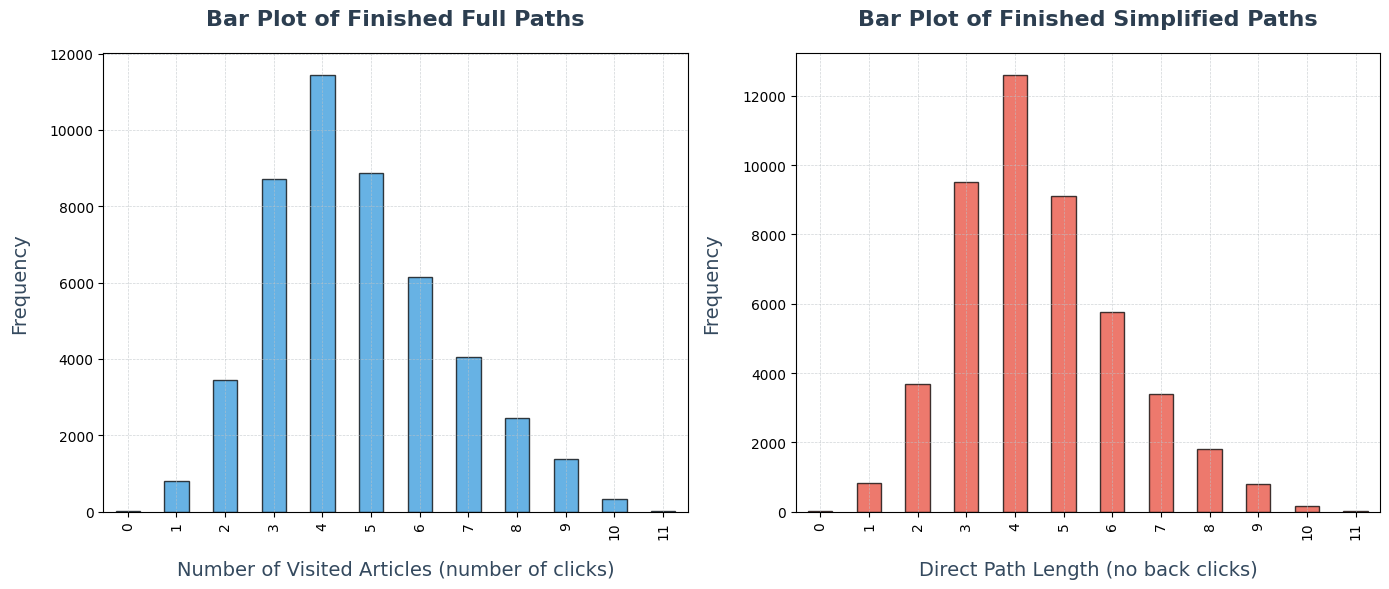

In [197]:
# Count occurrences of each path length
len_full_counts = filtered_finished_paths['full_path_length'].value_counts().sort_index()
len_simplified_counts = filtered_finished_paths['simplified_path_length'].value_counts().sort_index()

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the bar plot for full path lengths on the first subplot
len_full_counts.plot(kind='bar', color='#3498db', edgecolor='black', alpha=0.75, ax=axes[0])
axes[0].set_title("Bar Plot of Finished Full Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[0].set_xlabel("Number of Visited Articles (number of clicks)", fontsize=14, color='#34495E', labelpad=15)
axes[0].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines

# Plot the bar plot for simplified path lengths on the second subplot
len_simplified_counts.plot(kind='bar', color='#e74c3c', edgecolor='black', alpha=0.75, ax=axes[1])
axes[1].set_title("Bar Plot of Finished Simplified Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[1].set_xlabel("Direct Path Length (no back clicks)", fontsize=14, color='#34495E', labelpad=15)
axes[1].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



This looks pretty good! The cutoff seems reasonable. However, there are certain samples with '0' path length inbetween them. they need to be taken care of.

In [198]:
# we notice that there are some samples with distance 0 (start and target article are the same).
# these also need to be filtered out

filtered_finished_paths = filtered_finished_paths[~(filtered_finished_paths['distance']== 0)]

We now display the distribution of the unfinished articles.

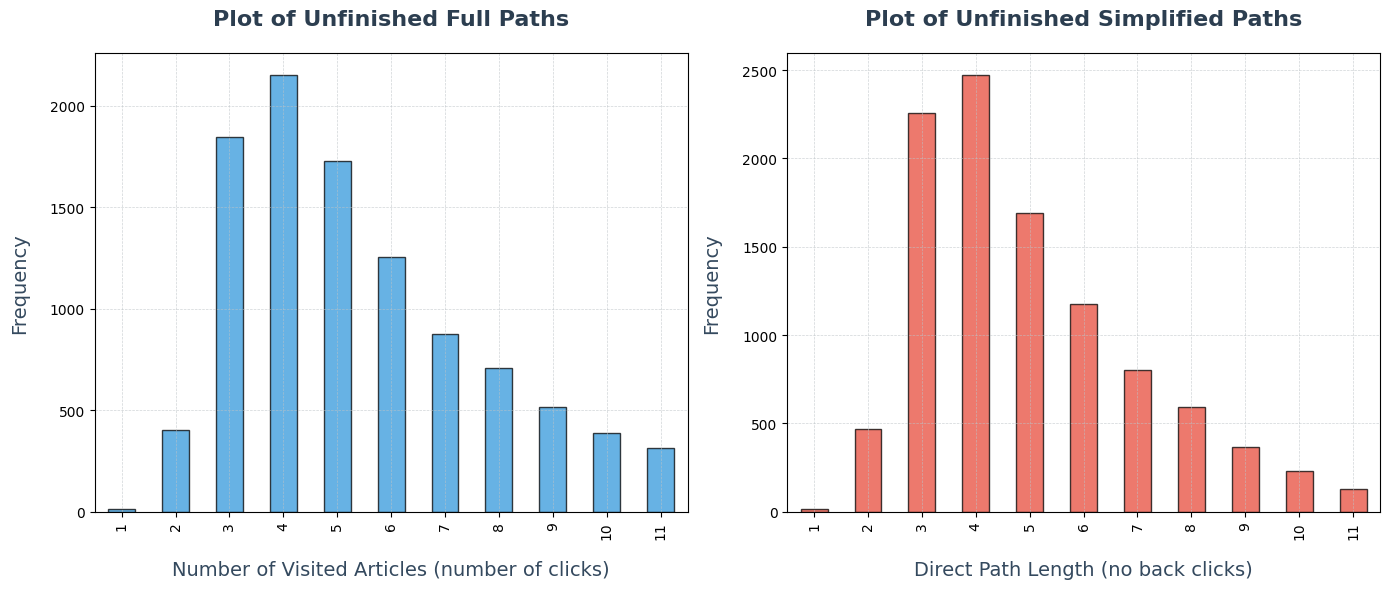

In [199]:
# Count occurrences of each path length
len_full_counts = filtered_unfinished_paths['full_path_length'].value_counts().sort_index()
len_simplified_counts = filtered_unfinished_paths['simplified_path_length'].value_counts().sort_index()

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the bar plot for full path lengths on the first subplot
len_full_counts.plot(kind='bar', color='#3498db', edgecolor='black', alpha=0.75, ax=axes[0])
axes[0].set_title("Plot of Unfinished Full Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[0].set_xlabel("Number of Visited Articles (number of clicks)", fontsize=14, color='#34495E', labelpad=15)
axes[0].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-ticks vertically

# Plot the bar plot for simplified path lengths on the second subplot
len_simplified_counts.plot(kind='bar', color='#e74c3c', edgecolor='black', alpha=0.75, ax=axes[1])
axes[1].set_title("Plot of Unfinished Simplified Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
axes[1].set_xlabel("Direct Path Length (no back clicks)", fontsize=14, color='#34495E', labelpad=15)
axes[1].set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-ticks vertically

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

 Again the cut-off seems reasonable, maybe a bit low on the upper bound, but we will keep it like this for now.

In [172]:
# finally we merge the finished and unfinished data frames
filtered_paths = pd.concat([filtered_finished_paths, filtered_unfinished_paths]).drop('length_minus_distance', axis=1)


For comparison let's also have a look at the distribution of the shortest possible distance distribution and its statistic. 

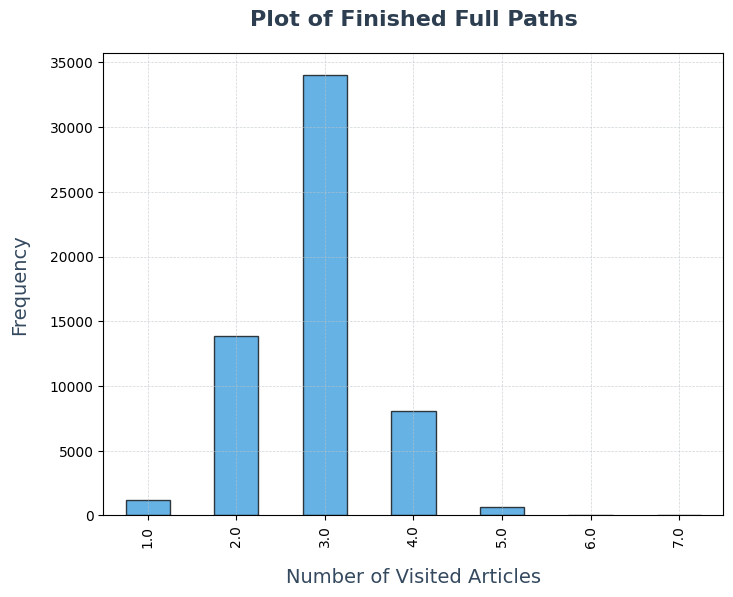

In [173]:
# Count occurrences of each distance
distance_counts = filtered_paths['distance'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot with the same design as above
distance_counts.plot(kind='bar', color='#3498db', edgecolor='black', alpha=0.75, ax=ax)
ax.set_title("Plot of Finished Full Paths", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
ax.set_xlabel("Number of Visited Articles", fontsize=14, color='#34495E', labelpad=15)
ax.set_ylabel("Frequency", fontsize=14, color='#34495E', labelpad=15)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#BDC3C7')  # Subtle gridlines
ax.tick_params(axis='x', rotation=90)  # Rotate x-ticks vertically

plt.show()

In [175]:
nan_count = filtered_paths['distance'].isna().sum()
print(f"There are {nan_count} NaN values in the 'distance' column.")

# look at some statistics

print("\nStatistics of 'distance' column:")
filtered_paths['distance'].describe()

There are 0 NaN values in the 'distance' column.

Statistics of 'distance' column:


count    57884.000000
mean         2.884683
std          0.710127
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          7.000000
Name: distance, dtype: float64

**Interesting observatin**

We just obversed that pretty much any article is reachable within at most 6 clicks (3 exeption with distance 7). This is interesting when we thik of the six degrees of separation idea...

## Start-Target article analysis

Now using the filtered path data we are interested in the distribution of the number of times the same start-target article pairs appear. Ideally this would be somewhat uniform.

In [176]:
start_target_groups = filtered_paths.groupby(['start_article', 'target_article'])
start_articles_groups = filtered_paths.groupby(['start_article'])
target_articles_groups = filtered_paths.groupby(['target_article'])


print(f"Start-Target pair group size statistics:\n    {start_target_groups.size().describe()}\n")
print(f"Sart article's group size statistics:\n    {start_articles_groups.size().describe()}\n")
print(f"Target article's group size statistics:\n    {target_articles_groups.size().describe()}\n")



Start-Target pair group size statistics:
    count    33674.000000
mean         1.718952
std         13.500968
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1308.000000
dtype: float64

Sart article's group size statistics:
    count    4157.000000
mean       13.924465
std        41.641078
min         1.000000
25%         7.000000
50%        10.000000
75%        16.000000
max      1357.000000
dtype: float64

Target article's group size statistics:
    count    3761.000000
mean       15.390588
std        45.002551
min         1.000000
25%         6.000000
50%        10.000000
75%        17.000000
max      1417.000000
dtype: float64



Clearly the distribution is not unfirom at all. Most games from a certain start article to target article were only attempted once but we also see that some are played over 1000 times! We can now try to find the most played paths and maybe already find out why they are played much more often.

In [306]:
# Group by 'start_article' and 'target_article' and aggregate
grouped = start_target_groups.agg(
    group_size=('target_article', 'size'),                      # Size of each group
    mean_full_path_length=('full_path_length', 'mean'),         # Mean of 'full_path_length'
    mean_simplified_path_length=('simplified_path_length', 'mean'),  # Mean of 'simplified_path_length'
    mean_rating=('rating', 'mean'),                             # Mean of 'rating' ignoring NaNs
    fraction_finished=('finished', 'mean')                    # fraction of 'finished' (mean of True/False)
).reset_index()

# Sort by group size in descending order and take the top 10 largest groups
top_groups = grouped.sort_values('group_size', ascending=False).head(10)

print("Top 10 largest groups by start_article and target_article pairs with some intesting metrics:\n", top_groups)

Top 10 largest groups by start_article and target_article pairs with some intesting metrics:
       start_article     target_article  group_size  mean_full_path_length  \
5169          Brain          Telephone        1308               5.075688   
2731       Asteroid             Viking        1284               5.497664   
30100       Theatre              Zebra        1201               5.517902   
24832       Pyramid               Bean        1075               5.362791   
3749         Batman               Wood         164               5.146341   
4475           Bird  Great_white_shark         142               4.260563   
3744         Batman      The_Holocaust         124               4.354839   
4092           Beer                Sun         121               4.008264   
4470           Bird       Adolf_Hitler         113               4.185841   
3712         Batman             Banana          80               5.687500   

       mean_simplified_path_length  mean_rating  fraction_

**Comment:** It appears that there is no abvious trend here. The most played start-target pairs are not the easiest which could have been the case due to players skipping the harder paths. This overrepresentation of some games is something we definetly need to take into consideration for further analysis!

**END OF PREPROCESSING & exploratory data analysis**
need to store filtered dataframe 

## game based top articles. (This should go somewhere else than in this file)

We will try to quantify what articles are the most important in user navigation using various approaches from simple to more complex
### Naive approach

First we just look at articles than come up the most in the filtered data. This is of course a very naive approach and will just serve as comparison for the subsequent ones.

In [189]:
# 1. naive approach described above.
# will use the simplied paths (direct paths) as contrary to full path more apperances necessary imply importance

simplified_paths = filtered_paths['simplified_path'].copy()

simplified_paths.apply(lambda l: l[1:-1]) # drop start and target article

article_count = pd.Series(dtype=int)

# Loop through each path and count each article
for path in simplified_paths:
    for article in path:
        article_count[article] = article_count.get(article, 0) + 1

# order 
article_count = article_count.sort_values(ascending=False)

article_count.head(10)

United_States     9745
Europe            4581
United_Kingdom    4148
England           3495
Earth             3418
Africa            2976
World_War_II      2382
North_America     1960
Germany           1793
Human             1727
dtype: int64

### Weighted Average of All Articles

This allows for averaging without being overly influenced by differences between the start and target pairs. We will define weight as: 
$$
\text{Weight} = 1 - \frac{\text{Actual Path Length} - \text{Optimal Distance}}{\text{Actual Path Length}} = \frac{\text{Optimal Path Length}}{\text{Actual Path Length}}
$$
This weight captures how much the actual path deviates from the optimal distance as a ratio of the actual path length.

The weighted average will allow us to evaluate the average quality of an article's appearances.

Note: I don't consider the start and target articles, in the paths, maybe keep targets ?

In [264]:
# we can only use finished paths for this analysis.
# use simplified path lengths for diff calculation

# 1. make new df where a weight is assigned to each path (both described above), and a col for simplified and full path
# 2. A function that takes this df and iterates through the simplified path column, where it checks what articles appear in it
# and adds that weight that row to a total weight sum of an other data frame. This other data frame should consit of the following rows:
# |article_name|n_counts|weighted_avg|normalized_path_score_avg|

# 1.
df = filtered_finished_paths[['simplified_path', 'simplified_path_length', 'distance']].copy()

# again drop start and end articles
df['simplified_path'] = df['simplified_path'].apply(lambda l: l[1:-1])

# Calc weight and add to df
df['weight'] = df['distance'] / df['simplified_path_length']

df.head()


,simplified_path,simplified_path_length,distance,weight
0,"[15th_century, 16th_century, Pacific_Ocean, At...",8,3.0,0.375000
1,"[Europe, Africa, Atlantic_slave_trade]",4,3.0,0.750000
2,"[Niger, Nigeria, British_Empire, Slavery, Afri...",7,3.0,0.428571
3,"[Renaissance, Ancient_Greece]",3,2.0,0.666667
4,"[Italy, Roman_Catholic_Church, HIV, Ronald_Rea...",6,3.0,0.500000


In [277]:
# 2. Create an empty DataFrame for aggregating article results 
avg_article_weight_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_avg'])
avg_article_weight_df.set_index('article', inplace=True)

for index, row in df.iterrows():
    weight = row['weight']
    simplified_path = row['simplified_path']

    if len(simplified_path) > 2:
        # Iterate through articles in the simplified path
        for article in simplified_path[1:-1]: # don't consider start and target articles
            if article not in avg_article_weight_df.index:
                # If the article is not in the DataFrame, initialize a new row
                avg_article_weight_df.loc[article] = [0, 0]

            # Update counts and weighted sums
            avg_article_weight_df.at[article, 'n_appearances'] += 1
            avg_article_weight_df.at[article, 'weighted_avg'] += weight

# Calculate the weighted average by dividing by the counts
avg_article_weight_df['weighted_avg'] = avg_article_weight_df['weighted_avg'] / avg_article_weight_df['n_appearances']

/var/folders/sj/219f9qbn3y15yynshcyrrp3c0000gn/T/ipykernel_42936/2742572372.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  avg_article_weight_df.at[article, 'weighted_avg'] += weight


In [278]:
avg_article_weight_df = avg_article_weight_df.sort_values(by='weighted_avg', ascending=False)
avg_article_weight_df

,n_appearances,weighted_avg
article,,
Zheng_He,1,1.00
Antimony,1,1.00
Badminton,1,1.00
H5N1,1,1.00
International_Red_Cross_and_Red_Crescent_Movement,1,1.00
...,...,...
Hammurabi,1,0.25
Akkadian_Empire,1,0.25
Henrik_Ibsen,1,0.25


Articles that only show up once in the whole paths considered are not assigned a meaningfull weight value. We need to filter again. Whe can for example only consider articles that at least appear 30 times. This would still leave us with a fairly large data set that we can use for further analysis.

In [293]:
filtered_weighted_avg_df = avg_article_weight_df[avg_article_weight_df['n_appearances'] >= 30]
filtered_weighted_avg_df

,n_appearances,weighted_avg
article,,
Extrasolar_planet,48,0.727364
Black_Sea,53,0.666584
Whale_shark,272,0.651068
Information,321,0.649007
International_law,31,0.643510
...,...,...
Bible,46,0.449474
Radio,85,0.449402
Athens,66,0.448088


### Weighted Sum of sampled articles

In this case, instead of taking the average of the weight per article we sum the wieghts over all articles. This metric will of course be larger for articles that appear more often. Thus, it will be less informative about article quality, but likely more meaningfull in showing what articles are the most usefull for players overall. 
To adjust for the imbalance in start-target pairs, we need to downsample the data to only 1 sample per pair. As we saw that over 50% of the data only has one such sample already, this should not result in a to large chunck of removed samples.

In [261]:
# first downsample the df so that there only is one sample per start-target pair.

# Set the random seed for reproducibility
np.random.seed(42)

shuffled_df = filtered_finished_paths.sample(frac=1).reset_index(drop=True)
filtered_paths_sampled = shuffled_df.drop_duplicates(subset='identifier', keep='first').reset_index(drop=True)

# Calculate the number of removed rows
removed = filtered_finished_paths.shape[0] - filtered_paths_sampled.shape[0]

# Print the result
print(f"In sampling a total of {removed} samples were removed, "
      f"which represents {removed / filtered_finished_paths.shape[0] * 100:.3f}% of the original data.",
      f"{filtered_paths_sampled.shape[0]} samples remain.")

In sampling a total of 20010 samples were removed, which represents 41.965% of the original data. 27673 samples remain.


In [282]:
# very similar code as for weighted average overall
df2 = filtered_paths_sampled[['simplified_path', 'simplified_path_length', 'distance']].copy()

# Calc weight and add to df
df2['weight'] = df2['distance'] / df2['simplified_path_length']

article_weightes_sum_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_sum'])
article_weightes_sum_df.set_index('article', inplace=True)

for index, row in df2.iterrows():
    weight = row['weight']
    simplified_path = row['simplified_path']

    if len(simplified_path) > 2:
        # Iterate through articles in the simplified path
        for article in simplified_path[1:-1]: # don't consider start and target articles
            if article not in article_weightes_sum_df.index:
                # If the article is not in the DataFrame, initialize a new row
                article_weightes_sum_df.loc[article] = [0, 0]

            # Update counts and weighted sums
            article_weightes_sum_df.at[article, 'n_appearances'] += 1
            article_weightes_sum_df.at[article, 'weighted_sum'] += weight

/var/folders/sj/219f9qbn3y15yynshcyrrp3c0000gn/T/ipykernel_42936/67396874.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  article_weightes_sum_df.at[article, 'weighted_sum'] += weight


In [298]:
article_weightes_sum_df = article_weightes_sum_df.sort_values(by='weighted_sum', ascending=False)

article_weightes_sum_df.head(10)

,n_appearances,weighted_sum
article,,
United_States,4534,3205.278499
Europe,2168,1423.762302
United_Kingdom,2113,1401.557143
England,1660,1083.717027
Africa,1364,930.151768
Earth,1187,763.651587
World_War_II,1104,757.799206
France,837,557.654762
Germany,811,556.206349


**Comment** 

This is not really a surprise, the articles that show up the most often also have the highest weighted_sum. Does that necessarily make them the best articles for efficient users to navigation? This is hard to tell as they are obviously different from highest 'quality' articles we extracted above.


Alternatively, we can center the weights around 0 before computing the weighted sum to reduce the bias introduced by the number of appearances of articles. This way, articles with more appearances won't necessarily lead to a disproportionately large weighted sum score. This can help highlight articles that are truly impactful relative to the average. 
To do so we use the follwoing formulas:

$$
\text{article\_mean\_weight} = \frac{\sum (\text{weight} \times \text{simplified\_path\_length})}{\sum (\text{simplified\_path\_length})}
$$

$$
\text{centered\_weight} = \text{weight} - \text{article\_mean\_weight}
$$

$$
\text{article\_weighted\_sum} = \sum \left( \text{centered\_weight} \times \text{n\_appearances} \right)
$$

In [285]:
# Calculate mean weight
article_mean_weight = (df2['weight'] * df2['simplified_path_length']).sum() / df2['simplified_path_length'].sum()

# Center the weights by subtracting the mean
df2['centered_weight'] = df2['weight'] - article_mean_weight

article_weightes_sum_df2 = pd.DataFrame(columns=['article_name', 'n_appearances', 'weighted_sum'])
article_weightes_sum_df2.set_index('article_name', inplace=True)

for index, row in df2.iterrows():
    centered_weight = row['centered_weight']
    simplified_path = row['simplified_path']

    if len(simplified_path) > 2:
        for article in simplified_path[1:-1]: # don't consider start and target articles
            if article not in article_weightes_sum_df2.index:
                article_weightes_sum_df2.loc[article] = [0, 0]  # Initialize count and sum

            # Update counts and centered weighted sum
            article_weightes_sum_df2.at[article, 'n_appearances'] += 1
            article_weightes_sum_df2.at[article, 'weighted_sum'] += centered_weight


/var/folders/sj/219f9qbn3y15yynshcyrrp3c0000gn/T/ipykernel_42936/3921379527.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09830571274589062' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  article_weightes_sum_df2.at[article, 'weighted_sum'] += centered_weight


In [299]:
article_weightes_sum_df2 = article_weightes_sum_df2.sort_values(by='weighted_sum', ascending=False)

article_weightes_sum_df2


,n_appearances,weighted_sum
article_name,,
United_States,4534,250.496601
Africa,1364,41.240760
World_War_II,1104,38.328713
Japan,484,28.509294
Germany,811,27.682282
...,...,...
Great_Britain,297,-23.702013
European_Union,431,-24.659206
Continent,305,-28.221520


Things have definetly changed let's compare the top scoring articles of the centered weighted sum vs weighted sum and the average weighted average.

In [303]:
# Again the articles that appear only few times should not be considered
article_weightes_sum_df2 = article_weightes_sum_df2[article_weightes_sum_df2['n_appearances'] >= 30]
article_weightes_sum_df2

,n_appearances,weighted_sum
article_name,,
United_States,4534,250.496601
Africa,1364,41.240760
World_War_II,1104,38.328713
Japan,484,28.509294
Germany,811,27.682282
...,...,...
Great_Britain,297,-23.702013
European_Union,431,-24.659206
Continent,305,-28.221520


**Comment**

It is obvious that in this apporach articles that appear much more often will also have the most extreme weight values. But this might be a decent compromise between article 'quality' and article 'usefulness' for players.

**Comparison** of the methods

In [301]:
top_n = 10

# Top articles
print(f"Top {top_n} articles for the Weighted Average Approach and their corresponding weights:")
print(filtered_weighted_avg_df.head(top_n))

print(f"\nTop {top_n} articles for the Standard Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df.head(top_n))

print(f"\nTop {top_n} articles for the Centered Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df2.head(top_n))

Top 10 articles for the Weighted Average Approach and their corresponding weights:
                             n_appearances  weighted_avg
article                                                 
Extrasolar_planet                       48      0.727364
Black_Sea                               53      0.666584
Whale_shark                            272      0.651068
Information                            321      0.649007
International_law                       31      0.643510
Tennis                                  46      0.637535
Aluminium                               39      0.622222
Bird                                   310      0.618967
Cinema_of_the_United_States            100      0.618742
Tropical_cyclone                       135      0.611177

Top 10 articles for the Standard Weighted Sum Approach and their corresponding weights:
                n_appearances  weighted_sum
article                                    
United_States            4534   3205.278499
Europe      

In [302]:
worst_n = 10

# Worst articles
print(f"\nWorst {worst_n} articles for the Weighted Average Approach and their corresponding weights:")
print(filtered_weighted_avg_df.tail(worst_n))

print(f"\nWorst {worst_n} articles for the Standard Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df.tail(worst_n))

print(f"\nWorst {worst_n} articles for the Centered Weighted Sum Approach and their corresponding weights:")
print(article_weightes_sum_df2.tail(worst_n))


Worst 10 articles for the Weighted Average Approach and their corresponding weights:
              n_appearances  weighted_avg
article                                  
Matter                   51      0.455096
History                  46      0.452088
Jesus                    45      0.451235
East_Africa              53      0.450382
Persian_Gulf             32      0.450149
Bible                    46      0.449474
Radio                    85      0.449402
Athens                   66      0.448088
Gardening                38      0.446805
Irrigation               54      0.430467

Worst 10 articles for the Standard Weighted Sum Approach and their corresponding weights:
                   n_appearances  weighted_sum
article                                       
Minstrel_show                  1      0.333333
Walter_Raleigh                 1      0.285714
William_McKinley               1      0.285714
Guglielmo_Marconi              1      0.285714
Hawk-Eye                       1     

### OTHER IDEA woking with the pairs where there is a ton of samples

We can also make use of the finding that we have over 1000 samples for certain pairs as this will allow for much more precise article scoring metrics. Thus in a third apporach we use only the top occuring start-target pairs and compute and rank the articles that appear using again the same weighted path length - distance approach but also considering if the unfinished paths, penalizing articles that appear in them...

In [324]:
# only consider the top 4 as they all have size > 1000
n = 4

identifier_grouped = filtered_paths.groupby(['identifier'])

# Sort by group size in descending order and take the top 10 largest groups
top_identifiers = identifier_grouped.size().sort_values(ascending=False).head(n).index

# extract all the paths from the filtered df with these identifiers
top_pairs_df = filtered_paths[filtered_paths['identifier'].isin(top_identifiers)].copy()

top_pairs_df.shape

(4868, 15)

In [ ]:
# steps from here 
# - similar metrics as above to get weights
# - can also consider additional metric => ratio nb of times apears article in unfinished over total nb of times article appears...
#   (I could incorporate this metric in the above as well maybe)
# - can also include a penalty to articles that are dead ends (consider difference between full_length_path and simpliifed...)
# - can do ML / regression to learn coeeficient of these two parameters...
